### Recap: The Learning Problem

We have a dataset of $(x, y)$ pairs where $x$ denotes a vector of features and $y$ denotes the label for that feature vector. We want to learn a function $h(x)$ that maps features to labels, with good generalization accuracy. We do this by minimizing a loss function computed on our dataset: $ \sum_{i=1}^{N} L(y_i, h(x_i)) $. There are many loss functions we can choose. We have gone over the cross-entropy loss and variants of the squared error loss functions in previous workshops, and we will once again consider those today. 


### Review: A Single "Neuron", aka the Perceptron

![perceptron](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/perceptron.png)

Previously, we sow how to calculate a **weighted sum** of our inputs, and then apply a **nonlinear** activation function to it to obtain a prediction between $0$ and $1$, which can be interpreted as a probability. 

First, we multiply each of our features $(x_1, x_2, ... x_n) \in x$ with an associated weight $(w_1, w_2, ... w_n)$ .

Next, we applied the sigmoid nonlinearity to this output. It turns out that if you're only aiming for binary classification, there's an even simpler approach than taking the sigmoid nonlinearity - just take the sign of the output as your predicted label (make an arbitary choice for zero). This model is called a **perceptron**, and the prediction function is given by $h(x) = sign(w^Tx + b) $.

Previously, we saw an even more general approach to classification than just taking the sign - using the sigmoid ($\sigma$) function. As a reminder, here's the sigmoid function: 

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/600px-Logistic-curve.svg.png)

Therefore, the function we compute for logistic regression is $h(x) = \sigma (w^Tx + b)$. As we get into neural networks, it's useful to start thinking about this classification model - taking a linear combination of our weights and passing them through a nonlinearity - as a **single unit** of computation. We will see how these individual units work together to make up a neural network. Here's a representation of such a unit: 
![sigmoidunit](https://raw.githubusercontent.com/uclaacmai/tf-workshop-series-fall17/master/week5-neural-networks/sigmoid_unit.png)

The sigmoid function is commonly referred to as an "activation" function. When we say that a "neuron computes an activation function", it means that a standard linear combination is calculated ($w^Tx + b$) and then we apply a _non linear_ function to it, such as the sigmoid function. 

Here are a few other common activation functions: 

![tanh](http://www.dplot.com/functions/tanh.png)
![relu](https://i.stack.imgur.com/8CGlM.png)

We will see that when we build up our neural network, we'll have to make a choice as to which activation function we should use. It turns out that each particular activation function has its benefits and disadvantages.


### Review: From binary to multi-class classification

The most important change in moving from a binary (negative/positive) classification model to one that can classify training instances into many different classes (say, 10, for MNIST) is that our vector of weights $w$ changes into a matrix $W$. 

Each row of weights we learn represents the parameters for a certain class: 

![weights](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/imagemap.jpg)

We also want to take our output and normalize the results so that they all sum to one, so that we can interpret them as probabilities. This is commonly done using the _softmax_ function, which takes in a vector and returns another vector whose elements sum to 1, and each element is proportional in scale to what it was in the original vector. In binary classification we used the sigmoid function to compute probabilities. Now since we have a vector, we use the softmax function.  

Here is our current model of learning, then:

$h(x) = softmax(Wx + b) $.

Looking at our example in the picture, we've computed $Wx + b$. Applying softmax to the output vector, $[-96.8,437.5, 61.95]$ produces $[9.04603615e^{-233},1.00000000000,7.95622985e^{-164}]$. Our prediction is taken as the index of the max value in this array, so we'd output 1 in this case.

### Building up the neural network

Now that we've figured out how to linearly model multi-class classification, we can create a basic neural network. Consider what happens when we combine the idea of artificial neurons with our softmax classifier. Instead of computing a linear function  $Wx + b$ and immediately passing the output to a softmax function, we have an intermediate step: pass the output of our linear combination to a vector of artificial neurons, which each compute a nonlinear function. 

The output of this "layer" of neurons can be multiplied with a matrix of weights again, and we can apply our softmax function to this result to produce our predictions. 

** Original function **: $h(x) = softmax(Wx + b)$

** Neural Network function **: $h(x) = softmax(W_2(nonlin(W_1x + b_1)) + b_2)$

The key differences are that we have more biases and weights, as well as a larger composition of functions. This function is harder to optimize, and introduces a few interesting ideas about learning the weights with an algorithm known as backpropagation.

This “intermediate step” is actually known as a hidden layer, and we have complete control over it, meaning that among other things, we can vary the number of parameters or connections between weights and neurons to obtain an optimal network. It’s also important to notice that we can stack an arbitrary amount of these hidden layers between the input and output of our network, and we can tune these layers individually. This lets us make our network as deep as we want it. For example, here’s what a neural network with two hidden layers would look like:

![neuralnet](https://raw.githubusercontent.com/rohan-varma/rohan-blog/gh-pages/images/neuralnet.png)

We're now ready to start implementing a basic neural network in Tensorflow. 


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


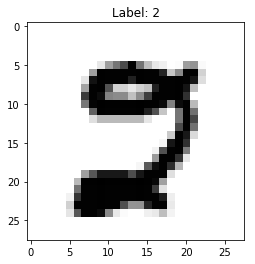

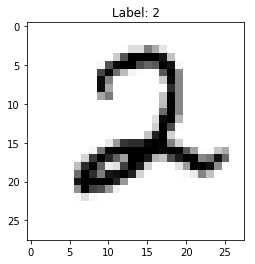

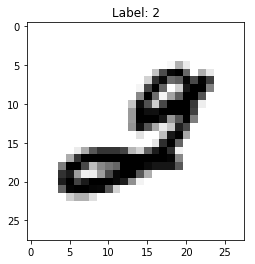

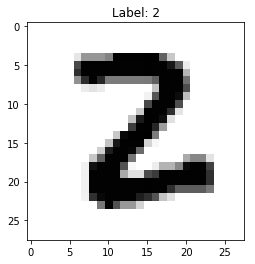

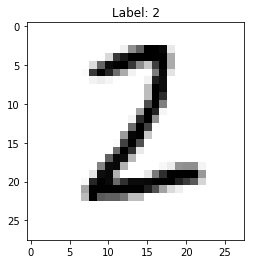

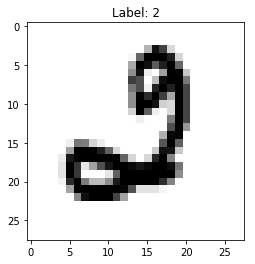

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True) # reads in the MNIST dataset


# a function that shows examples from the dataset. If num is specified (between 0 and 9), then only pictures with those labels will beused
def show_pics(mnist, num = None):
    to_show = list(range(10)) if not num else [num]*10 # figure out which numbers we should show
    for i in range(100):
        batch = mnist.train.next_batch(1) # gets some examples
        pic, label = batch[0], batch[1]
        if np.argmax(label) in to_show:
            # use matplotlib to plot it
            pic = pic.reshape((28,28))
            plt.title("Label: {}".format(np.argmax(label)))
            plt.imshow(pic, cmap = 'binary')
            plt.show()
            to_show.remove(np.argmax(label))
            
            

#show_pics(mnist)
show_pics(mnist, 2)
        
        

As usual, we would like to define several variables to represent our weight matrices and our biases. We will also need to create placeholders to hold our actual data. Anytime we want to create variables or placeholders, we must have a sense of the **shape** of our data so that Tensorflow has no issues in carrying out the numerical computations. 

In addition, neural networks rely on various hyperparameters, some of which will be defined below. Two important ones are the ** learning rate ** and the number of neurons in our hidden layer. Depending on these settings, the accuracy of the network may greatly change. 

In [4]:
# some functions for quick variable creation
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape = shape))

# hyperparameters we will use
learning_rate = 0.1
hidden_layer_neurons = 50
num_iterations = 5000

# placeholder variables
x = tf.placeholder(tf.float32, shape = [None, 784]) # none = the size of that dimension doesn't matter. why is that okay here? 
y_ = tf.placeholder(tf.float32, shape = [None, 10])

We will now actually create all of the variables we need, and define our neural network as a series of function computations. 

In our first layer, we take our inputs that have dimension $n * 784$, and multiply them with weights that have dimension $ 784 * k $, where $k$ is the number of neurons in the hidden layer. We then add the biases to this result, which also have a dimension of $k$. 

Finally, we apply a nonlinearity to our result. There are, as discussed, several choices, three of which are tanh, sigmoid, and rectifier. We have chosen to use the rectifier (also known as relu, standing for Rectified Linear Unit), since it has been shown in both research and practice that they tend to outperform and learn faster than other activation functions. 

Therefore, the "activations" of our hidden layer are given by $h_1 = relu(Wx + b)$. 

We follow a similar procedure for our output layer. Our activations have a shape $n * k$, where $n$ is the number of training examples we input into our network and $k$ is the number of neurons in our hidden layer. 

We want our final outputs to have dimension $n * 10$ (in the case of MNIST) since we have 10 classes. Therefore, it makes sense for our second matrix of weights to have dimension $k * 10$ and the bias to have dimension $10$. 

After taking the linear combination $W_2(h_1) + b$, we would then apply the softmax function. However, applying the softmax function and then writing out the cross-entropy loss ourself could result in numerical unstability, so we will instead use a library call that computes both the softmax outputs and the cross entropy loss. 

In [6]:
# create our weights and biases for our first hidden layer
W_1, b_1 = weight_variable([784, hidden_layer_neurons]), bias_variable([hidden_layer_neurons])

# compute activations of the hidden layer
h_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)

W_2_hidden = weight_variable([hidden_layer_neurons, 30])
b_2_hidden = bias_variable([30])
h_2 = tf.nn.relu(tf.matmul(h_1, W_2_hidden) + b_2_hidden)
# create our weights and biases for our output layer
W_2, b_2 = weight_variable([30, 10]), bias_variable([10])
# compute the of the output layer
y = tf.matmul(h_2,W_2) + b_2



The cross entropy loss function is a commonly used loss function. For a single prediction/label pair, it is given by $C(h(x), y) = -\sum_i y_i log(h(x_i))$.*

Here, $y$ is a specific one-hot encoded label vector, meaning that it is a column vector that has a 1 at the index corresponding to its label, and is zero everywhere else. $ h(x) $ is the output of our prediction function whose elements sum to 1. As an example, we may have: 

$$y = \begin{bmatrix}
           1 \\
           0 \\
           0 
         \end{bmatrix}, h(x_i) = \begin{bmatrix}
           0.2 \\
           0.7 \\
           0.1 
         \end{bmatrix} \longrightarrow{} C(y, h(x)) = -\sum_{i=1}^{N}y_ilog(h(x_i)) = -log(0.2) = 0.61 $$
         
The contribution to the entire training data's loss by this pair was 0.61. To contrast, we can swap the first two probabilities in our softmax vector. We then end up with a lower loss: 

$$y = \begin{bmatrix}
           1 \\
           0 \\
           0 
         \end{bmatrix}, h(x) = \begin{bmatrix}
           0.7 \\
           0.2 \\
           0.1 
         \end{bmatrix} \longrightarrow{} C(y, h(x)) = -\sum_{i=1}^{N}y_ilog(h(x_i)) = -log(0.7) = 0.15 $$

So our cross-entropy loss makes intuitive sense: it is lower when our softmax vector has a high probability at the index of the true label, and it is higher when our probabilities indicate a wrong or uncertain choice.

**Sanity check: why do we need the negative sign outside the sum?**



In [7]:
# define our loss function as the cross entropy loss
cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))

# create an optimizer to minimize our cross entropy loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_loss)

# functions that allow us to gauge accuracy of our model
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)) # creates a vector where each element is T or F, denoting whether our prediction was right
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32)) # maps the boolean values to 1.0 or 0.0 and calculates the accuracy

# we will need to run this in our session to initialize our weights and biases. 
init = tf.global_variables_initializer()

With all of our variables created and computation graph defined, we can now launch the graph in a session and begin training. It is important to remember that since we declared the $x$ and $y$ variables as placeholders, we will need to feed in data to run our optimizer that minimizes the cross entropy loss. 

The data we will feed in (by passing into our function a dictionary *feed_dict*) will come from the MNIST dataset. To randomly sample 100 training examples, we can use a wrapper provided by Tensorflow: ```mnnist.train.next_batch(100)```. 

When we run the optimizer with the call ```optimizer.run(..)``` Tensorflow calculates a forward pass for us (essentially propagating our data through the graph we have described), and then uses the loss function we created to evaluate the loss, and then computes partial derivatives with respect to each set of weights and updates the weights according to the partial derivatives. This is called the backpropagation algorithm, and it involves significant application of the chain rule. CS 231N provides an [excellent explanation](http://cs231n.github.io/optimization-2/) of backpropagation. 

In [8]:
# launch a session to run our graph defined above. 
with tf.Session() as sess:
    sess.run(init) # initializes our variables
    for i in range(num_iterations):
        # get a sample of the dataset and run the optimizer, which calculates a forward pass and then runs the backpropagation algorithm to improve the weights
        batch = mnist.train.next_batch(100)
        optimizer.run(feed_dict = {x: batch[0], y_: batch[1]})
        # every 100 iterations, print out the accuracy
        if i % 100 == 0:
            # accuracy and loss are both functions that take (x, y) pairs as input, and run a forward pass through the network to obtain a prediction, and then compares the prediction with the actual y.
            acc = accuracy.eval(feed_dict = {x: batch[0], y_: batch[1]})
            loss = cross_entropy_loss.eval(feed_dict = {x: batch[0], y_: batch[1]})
            print("Epoch: {}, accuracy: {}, loss: {}".format(i, acc, loss))
            
     # evaluate our testing accuracy       
    acc = accuracy.eval(feed_dict = {x: mnist.test.images, y_: mnist.test.labels})
    print("testing accuracy: {}".format(acc))
        

Epoch: 0, accuracy: 0.07999999821186066, loss: 2.2931833267211914
Epoch: 100, accuracy: 0.8399999737739563, loss: 0.6990350484848022
Epoch: 200, accuracy: 0.8700000047683716, loss: 0.35569435358047485
Epoch: 300, accuracy: 0.9300000071525574, loss: 0.26591774821281433
Epoch: 400, accuracy: 0.8999999761581421, loss: 0.3307000696659088
Epoch: 500, accuracy: 0.9399999976158142, loss: 0.23977749049663544
Epoch: 600, accuracy: 0.9800000190734863, loss: 0.09397666901350021
Epoch: 700, accuracy: 0.9200000166893005, loss: 0.2931550145149231
Epoch: 800, accuracy: 0.9399999976158142, loss: 0.20180968940258026
Epoch: 900, accuracy: 0.949999988079071, loss: 0.18461622297763824
Epoch: 1000, accuracy: 0.9700000286102295, loss: 0.18968147039413452
Epoch: 1100, accuracy: 0.9599999785423279, loss: 0.14828498661518097
Epoch: 1200, accuracy: 0.949999988079071, loss: 0.1613173633813858
Epoch: 1300, accuracy: 0.9800000190734863, loss: 0.10008890926837921
Epoch: 1400, accuracy: 0.9900000095367432, loss: 0.0

### Questions to Ponder

- Why bother with neural networks in the first place? Clearly, we saw much higher accuracy on the MNIST dataset than we were able to do with logistic regression, but why is this? How do additional layers and nonlinear activation functions chance the decision boundary that we learn, and why can this lead to better accuracy?
- Why is the test accuracy lower than the (final) training accuracy ?
- How can we tune our hyperparameters? In practice, is it okay to continually search for the best performance on the test dataset? 
- When we add additional layers to our learning model, how does gradient descent change? In particular, why is it important to be extra careful about our learning rate, have sensible initialization, and tune hyperparameters?
- Why do we use only 100 examples in each iteration, as opposed to the entire dataset of 50,000 examples? 

### Exercises
1. Using different activation functions. Consult the Tensorflow documentation on `tanh` and `sigmoid`, and use that as the activation function instead of `relu`. Gauge the resulting changes in accuracy. 
2. Varying the number of neurons - as mentioned, we have complete control over the number of neurons in our hidden layer. How does the testing accuracy change with a small number of neurons versus a large number of neurons? What about the generalization accuracy (with respect to the testing accuracy?)
3. Using different loss functions - we have discussed the cross entropy loss. Another common loss function used in neural networks is the MSE loss. Consult the Tensorflow documentation and implement the ```MSELoss()``` function. 
4. Addition of another hidden layer - We can create a deeper neural network with additional hidden layers. Similar to how we created our original hidden layer, you will have to figure out the dimensions for the weights (and biases) by looking at the dimension of the previous layer, and deciding on the number of neurons you would like to use. Once you have decided this, you can simply insert another layer into the network with only a few lines of code: 
    1. Use ```weight_variable()``` and ```bias_variable()``` to create new variables for the additional layer (remember to specify the shape correctly). 
    2. Similar to computing the activations for the first layer, ```h_1 = tf.nn.relu(...)```, compute the activations for your additional hidden layer. 
    3. Remember to change your output weight dimensions in order to reflect the number of neurons in the previous layer. 

### Additional Challenges
5. [Regularization](http://neuralnetworksanddeeplearning.com/chap3.html) is a popular approach to mitigage the overfitting issue in machine learning. Add L2-regularization to this model (see the documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss)), by adding an extra expression that calculates the squared norm of the weights. What does this change with regards to the optimization problem we are now solving? 
6. A technique to prevent overfitting that has worked very well in recent years is [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), a method that was only introdcued in 2014. Dropout is essentially discarding some proportion (usually half) of a layer's activations (setting them to zero). Once you've added dropout to your network, how does your training and testing accuracy change? 
6. The [momentum method](https://www.coursera.org/learn/neural-networks/lecture/Oya9a/the-momentum-method) is an increasingly popular approach to train deep neural networks. Momentum takes into account the previous gradients computed earlier on in the main learning loop, and uses those gradients to "guide" the descent towards a local minimum. Instead of using the `GradientDescentOptimizer` as we did, use the `MomentumOptimizer`. Momentum also introduces another hyperparameter that must be tuned. What does this hyperparameter mean, and how can we find a sensible value for it? 
7. Decaying the learning rate across time is another useful method to increase our algorithm's accuracy. Intuitively, we'd expect our algorithm, in the beginning training steps, to make large descents towards a local minima and rapidly adjust it's weights, but when our accuracy is very high, we'd only want to make very small, incremental improvements towards the local minima, since we are already around it. Add learning rate decay to the network. As a hint, we will no longer be able to set the learning rate as a constant, rather, we'd have to feed it in using `feed_dict`, much like we feed in our training inputs. 


 *Technical note: The way this loss function is presented is such that activations corresponding to a label of zero are not penalized at all. The full form of the cross-entropy loss is given by $C(y, h(x)) = \sum_i y_i log(h(x_i)) + (1 - y_i)(log(1 - h(x_i)) $. However, the previously presented function works just as well in environments with larger amounts of data samples and training for many epochs (passes through the dataset), which is typically the case for neural networks. 
